In [1]:
import tensorflow as tf

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks

from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing import image

import numpy as np

import matplotlib.pyplot as plt

import os

import glob

from google.colab import files 

# Data

## Load data

In [2]:
! pip install -q kaggle

In [3]:
# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"up201407851","key":"e4cbc7f62b0013c9d06dcfcf058efa98"}'}

In [4]:
! mkdir ~/.kaggle 


In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d moltean/fruits

 99% 753M/760M [00:16<00:00, 41.7MB/s]
100% 760M/760M [00:16<00:00, 48.6MB/s]


In [8]:
! unzip fruits.zip

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360/Training/Tomato 3/124_100.jpg  
  inflating: fruits-360/Training/Tomato 3/125_100.jpg  
  inflating: fruits-360/Training/Tomato 3/126_100.jpg  
  inflating: fruits-360/Training/Tomato 3/127_100.jpg  
  inflating: fruits-360/Training/Tomato 3/128_100.jpg  
  inflating: fruits-360/Training/Tomato 3/129_100.jpg

## Read Data

In [2]:
def load_images(path):
    X = []
    y = []
    folders_names = os.listdir(path)
    for folder in folders_names:
        folder_path = os.path.join(path, folder)
        img_paths = glob.glob(folder_path + r"/*.jpg")
        for img_path in img_paths[:100]:
            img = image.load_img(img_path)
            img = image.img_to_array(img) / 255.
            X.append(img)
            y.append(folder.split()[0])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [3]:
X_train, y_train = load_images(r"fruits-360/Training")
print(X_train.shape)

(13100, 100, 100, 3)


In [4]:
# Shuffle data.
idx = np.random.permutation(len(X_train))
X_train = X_train[idx]
y_train = y_train[idx]

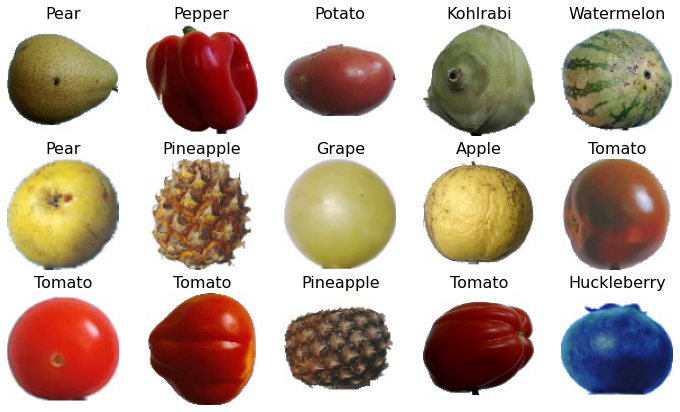

In [5]:
# Plot some images.
n_images = 15
plt.figure(figsize=(12, 7))
for idx in range(n_images):
    plt.subplot(n_images // 5, 5, idx+1)
    plt.imshow(X_train[idx])
    plt.title(y_train[idx], fontsize=16)
    plt.axis("off")
plt.show()

In [6]:
# Build a tensorflow dataset.
batch_size = 32
train_set = tf.data.Dataset.from_tensor_slices((X_train, X_train)).shuffle(len(X_train)).batch(batch_size, drop_remainder=True).prefetch(1)

# Variational Autoencoder

## Build model

In [26]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(mean)) * K.exp(log_var / 2) + mean

In [27]:
coding_size = len(np.unique(y_train))
inputs = layers.Input(shape=[100, 100, 3])
z = layers.Flatten()(inputs)
z = layers.Dense(500, activation="selu")(z)
z = layers.Dense(400, activation="selu")(z)
z = layers.Dense(300, activation="selu")(z)
codings_mean = layers.Dense(coding_size)(z)
codings_log_var = layers.Dense(coding_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
encoder = models.Model(inputs=[inputs], outputs=[codings])

encoder.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 30000)        0           input_6[0][0]                    
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 500)          15000500    flatten_3[0][0]                  
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 400)          200400      dense_23[0][0]                   
_______________________________________________________________________________________

In [28]:
decoder_inputs = layers.Input(shape=[coding_size])
x = layers.Dense(300, activation="selu")(decoder_inputs)
x = layers.Dense(400, activation="selu")(x)
x = layers.Dense(500, activation="selu")(x)
x = layers.Dense(3*100*100, activation="sigmoid")(x)
outputs = layers.Reshape([100, 100, 3])(x)
decoder = models.Model(inputs=[decoder_inputs], outputs=[outputs])

decoder.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 67)]              0         
_________________________________________________________________
dense_28 (Dense)             (None, 300)               20400     
_________________________________________________________________
dense_29 (Dense)             (None, 400)               120400    
_________________________________________________________________
dense_30 (Dense)             (None, 500)               200500    
_________________________________________________________________
dense_31 (Dense)             (None, 30000)             15030000  
_________________________________________________________________
reshape_2 (Reshape)          (None, 100, 100, 3)       0         
Total params: 15,371,300
Trainable params: 15,371,300
Non-trainable params: 0
__________________________________________

In [29]:
codings = encoder(inputs)
reconstruction = decoder(codings)

variational_ae = models.Model(inputs=[inputs], outputs=[reconstruction])

In [30]:
# Add latent loss.
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1
)

variational_ae.add_loss(K.mean(latent_loss) / 30000.)

In [31]:
optimizer = optimizers.Nadam(learning_rate=1e-4)

variational_ae.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
)

early_stop_cb = callbacks.EarlyStopping(patience=3, monitor="loss", restore_best_weights=True)
reduce_lr_cb = callbacks.ReduceLROnPlateau(patience=2, monitor="loss", factor=0.1, min_lr=1e-8, verbose=1)

## Train model

In [32]:
variational_ae.fit(
    train_set,
    epochs=100,
    callbacks=[early_stop_cb, reduce_lr_cb]
)


Epoch 1/100
409/409 [==============================] - 8s 19ms/step - loss: 0.4534
Epoch 2/100
409/409 [==============================] - 9s 22ms/step - loss: 0.4069
Epoch 3/100
409/409 [==============================] - 8s 20ms/step - loss: 0.3954
Epoch 4/100
409/409 [==============================] - 8s 20ms/step - loss: 0.3866
Epoch 5/100
409/409 [==============================] - 8s 20ms/step - loss: 0.3812
Epoch 6/100
409/409 [==============================] - 8s 19ms/step - loss: 0.3780
Epoch 7/100
409/409 [==============================] - 8s 19ms/step - loss: 0.3758
Epoch 8/100
409/409 [==============================] - 8s 19ms/step - loss: 0.3741
Epoch 9/100
409/409 [==============================] - 8s 19ms/step - loss: 0.3725
Epoch 10/100
409/409 [==============================] - 8s 19ms/step - loss: 0.3713
Epoch 11/100
409/409 [==============================] - 8s 20ms/step - loss: 0.3700
Epoch 12/100
409/409 [==============================] - 8s 20ms/step - loss: 0.3690
E

## Generate images

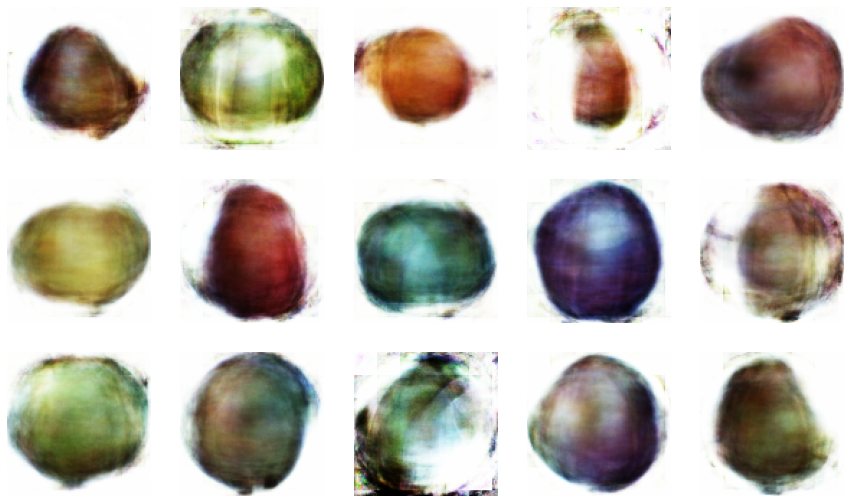

In [33]:
codings = tf.random.normal(shape=[15, coding_size])

imgs = decoder(codings)

n_images = 15
plt.figure(figsize=(15, 9))
for idx in range(n_images):
    plt.subplot(n_images // 5, 5, idx+1)
    plt.imshow(imgs[idx])
    plt.axis("off")
plt.show()

# Variational Autoencoder (Conv)

## Build model

In [34]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(mean)) * K.exp(log_var / 2) + mean

In [35]:
coding_size = len(np.unique(y_train))
inputs = layers.Input(shape=[100, 100, 3])
z = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
z = layers.MaxPool2D(3)(z)
z = layers.Conv2D(128, 3, padding="same", activation="relu")(z)
z = layers.MaxPool2D(3)(z)
z = layers.Conv2D(256, 3, padding="same", activation="relu")(z)
z = layers.MaxPool2D(3)(z)
z = layers.Conv2D(518, 3, padding="same", activation="relu")(z)
z = layers.MaxPool2D(3)(z)
z = layers.Flatten()(z)
codings_mean = layers.Dense(coding_size)(z)
codings_log_var = layers.Dense(coding_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
encoder = models.Model(inputs=[inputs], outputs=[codings])

encoder.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 33, 33, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 33, 33, 128)  73856       max_pooling2d[0][0]              
______________________________________________________________________________________

In [36]:
decoder_inputs = layers.Input(shape=[coding_size])
x = layers.Dense(518)(decoder_inputs)
x = layers.Reshape([1, 1, 518])(x)
x = layers.Conv2DTranspose(256, 3, strides=1, padding="valid", activation="relu")(x)
x = layers.Conv2DTranspose(128, 5, strides=3, padding="valid", activation="relu")(x)
x = layers.Conv2DTranspose(64, 3, strides=3, padding="valid", activation="relu")(x)
outputs = layers.Conv2DTranspose(3, 4, strides=3, padding="valid", activation="sigmoid")(x)
decoder = models.Model(inputs=[decoder_inputs], outputs=[outputs])

decoder.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 67)]              0         
_________________________________________________________________
dense_34 (Dense)             (None, 518)               35224     
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 1, 518)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 3, 3, 256)         1193728   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 11, 11, 128)       819328    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 33, 33, 64)        73792     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 100, 100, 3)     

In [37]:
codings = encoder(inputs)
reconstruction = decoder(codings)

variational_ae = models.Model(inputs=[inputs], outputs=[reconstruction])

In [38]:
# Add latent loss.
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1
)

variational_ae.add_loss(K.mean(latent_loss) / 30000.)

In [39]:
variational_ae.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
)

early_stop_cb = callbacks.EarlyStopping(patience=3, monitor="loss", restore_best_weights=True)
reduce_lr_cb = callbacks.ReduceLROnPlateau(patience=2, monitor="loss", factor=0.1, min_lr=1e-8, verbose=1)

## Train model

In [40]:
variational_ae.fit(
    train_set,
    epochs=100,
    callbacks=[early_stop_cb, reduce_lr_cb]
)


Epoch 1/100
409/409 [==============================] - 10s 25ms/step - loss: 0.4944
Epoch 2/100
409/409 [==============================] - 10s 25ms/step - loss: 0.4041
Epoch 3/100
409/409 [==============================] - 10s 25ms/step - loss: 0.3874
Epoch 4/100
409/409 [==============================] - 10s 25ms/step - loss: 0.3798
Epoch 5/100
409/409 [==============================] - 10s 25ms/step - loss: 0.3751
Epoch 6/100
409/409 [==============================] - 10s 25ms/step - loss: 0.3716
Epoch 7/100
409/409 [==============================] - 10s 25ms/step - loss: 0.3691
Epoch 8/100
409/409 [==============================] - 10s 25ms/step - loss: 0.3671
Epoch 9/100
409/409 [==============================] - 10s 25ms/step - loss: 0.3653
Epoch 10/100
409/409 [==============================] - 10s 25ms/step - loss: 0.3639
Epoch 11/100
409/409 [==============================] - 10s 25ms/step - loss: 0.3628
Epoch 12/100
409/409 [==============================] - 10s 25ms/step - lo

## Generate images

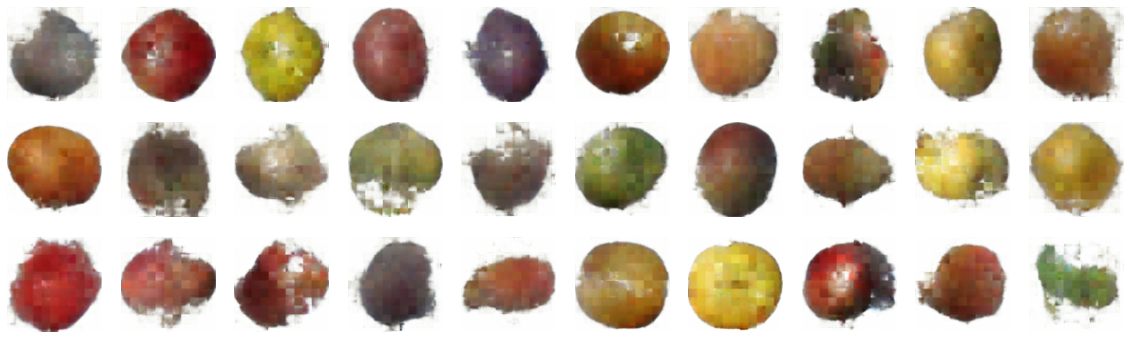

In [41]:
n_images = 30
codings = tf.random.normal(shape=[n_images, coding_size])

imgs = decoder(codings)

plt.figure(figsize=( 2 * 10, 2 * n_images // 10))
for idx in range(n_images):
    plt.subplot(n_images // 10, 10, idx+1)
    plt.imshow(imgs[idx])
    plt.axis("off")
plt.show()

# GAN

In [7]:
coding_size = 100

Generator

In [8]:
inputs = layers.Input(shape=[100])
z = layers.Dense(6*6*256, use_bias=False)(inputs)
z = layers.BatchNormalization()(z)
z = layers.LeakyReLU(0.2)(z)

z = layers.Reshape([6, 6, 256])(z)

z = layers.Conv2DTranspose(128, 5, strides=2, padding="same", use_bias=False)(z)
z = layers.BatchNormalization()(z)
z = layers.LeakyReLU(0.2)(z)

z = layers.Conv2DTranspose(64, 3, strides=2, padding="valid", use_bias=False)(z)
z = layers.BatchNormalization()(z)
z = layers.LeakyReLU(0.2)(z)

z = layers.Conv2DTranspose(32, 5, strides=2, padding="same", use_bias=False)(z)
z = layers.BatchNormalization()(z)
z = layers.LeakyReLU(0.2)(z)

outputs = layers.Conv2DTranspose(3, 1, strides=2, padding="same", activation="tanh")(z)

generator = models.Model(inputs=[inputs], outputs=[outputs])

In [9]:
generator.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 9216)              921600    
_________________________________________________________________
batch_normalization (BatchNo (None, 9216)              36864     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 9216)              0         
_________________________________________________________________
reshape (Reshape)            (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 12, 12, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 128)      

Discriminator

In [10]:
inputs = layers.Input(shape=[100, 100, 3])

z = layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
z = layers.BatchNormalization()(z)
z = layers.LeakyReLU(0.2)(z)

z = layers.Conv2D(64, 3, padding="same", use_bias=False)(z)
z = layers.BatchNormalization()(z)
z = layers.LeakyReLU(0.2)(z)

z = layers.Conv2D(128, 3, padding="same", use_bias=False)(z)
z = layers.BatchNormalization()(z)
z = layers.LeakyReLU(0.2)(z)

z = layers.Conv2D(256, 3, padding="same", use_bias=False)(z)
z = layers.BatchNormalization()(z)
z = layers.LeakyReLU(0.2)(z)

z = layers.Flatten()(z)
outputs = layers.Dense(1, activation="sigmoid")(z)

discriminator = models.Model(inputs=[inputs], outputs=[outputs])

In [11]:
discriminator.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 32)      864       
_________________________________________________________________
batch_normalization_4 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      18432     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100, 100, 64)      256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 100, 100, 64)     

In [12]:
discriminator.compile(
    optimizer=optimizers.Adam(lr=1e-4),
    loss="binary_crossentropy"
)

GAN

In [13]:
discriminator.trainable = False 
gan = models.Sequential([generator, discriminator])

In [14]:
gan.compile(
    optimizer=optimizers.Adam(lr=1e-4),
    loss="binary_crossentropy"
)

## Train GAN

Because we use the tanh activation in the final layer of the generator we have to rescale the training data to be between -1 and 1.

In [15]:
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices(X_train * 2 - 1).shuffle(len(X_train)).batch(batch_size, drop_remainder=True).prefetch(1)

In [19]:
def train_gan(gan, dataset, batch_size, coding_size, n_epochs):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    losses = []
    for X_batch in dataset:
      # Train discriminator.
      noise = tf.random.normal(shape=[batch_size, coding_size])
      generated = generator(noise)
      X1 = tf.concat([generated, X_batch], axis=0)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X1, y1)

      # Train generator.
      noise = tf.random.normal(shape=[batch_size, coding_size])
      y2 = tf.constant([[1.]] * batch_size)
      discriminator.trainable = False
      loss = gan.train_on_batch(noise, y2)
      losses.append(loss)
    
    print(r"Loss: {:.5f}".formaet(np.mean(losses)))
    noise = tf.random.normal(shape=[9, coding_size])
    imgs = (generator(noise) + 1) / 2
    plt.figure(figsize=(9, 1))
    for idx in range(9):
      plt.subplot(1, 9, idx+1)
      plt.imshow(imgs[idx].numpy(), cmap="binary")
      plt.axis("off")
    plt.show()


Epoch: 0


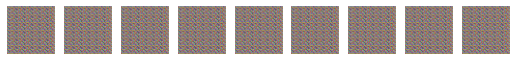

Epoch: 1


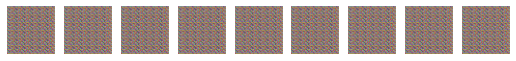

Epoch: 2


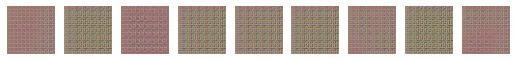

Epoch: 3


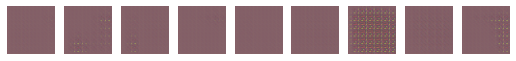

Epoch: 4


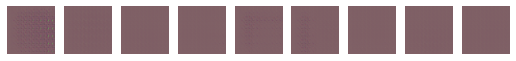

Epoch: 5


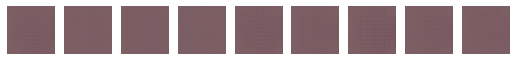

Epoch: 6


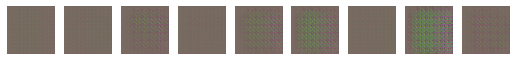

Epoch: 7


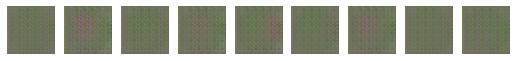

Epoch: 8


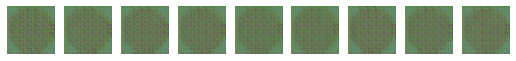

Epoch: 9


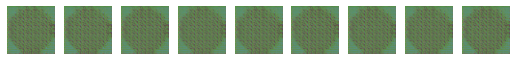

Epoch: 10


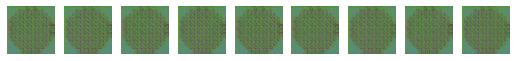

Epoch: 11


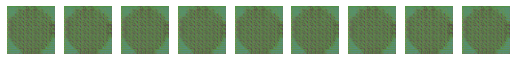

Epoch: 12


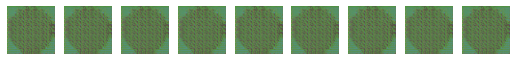

Epoch: 13


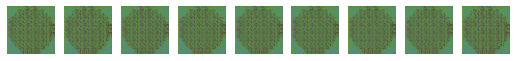

Epoch: 14


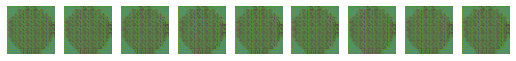

Epoch: 15


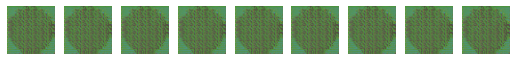

Epoch: 16


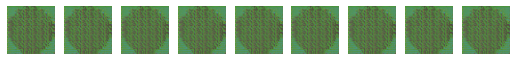

Epoch: 17


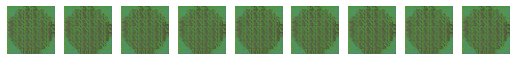

Epoch: 18


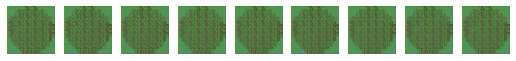

Epoch: 19


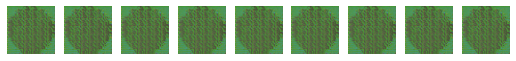

Epoch: 20


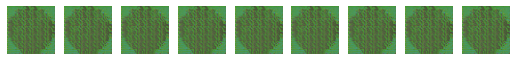

Epoch: 21


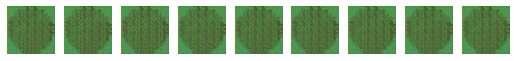

Epoch: 22


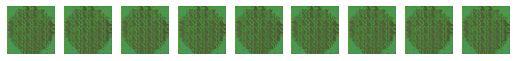

Epoch: 23


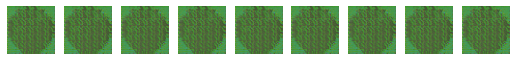

Epoch: 24


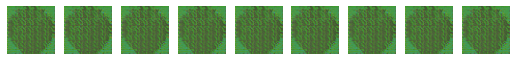

Epoch: 25


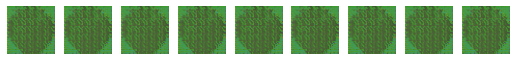

Epoch: 26


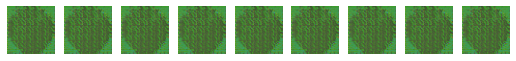

Epoch: 27


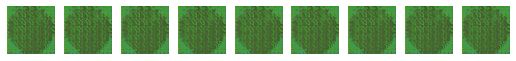

Epoch: 28


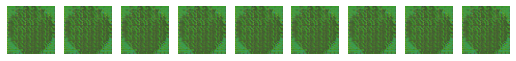

Epoch: 29


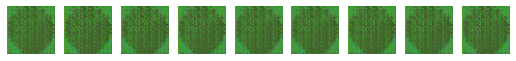

Epoch: 30


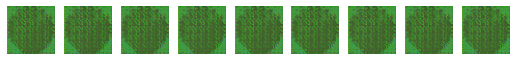

Epoch: 31


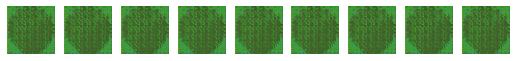

Epoch: 32


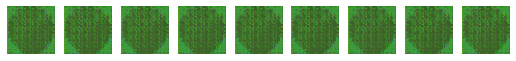

Epoch: 33


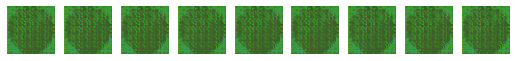

Epoch: 34


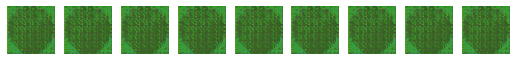

Epoch: 35


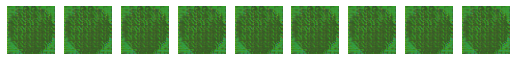

Epoch: 36


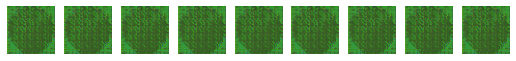

Epoch: 37


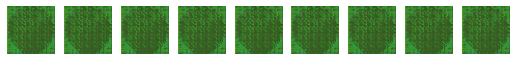

Epoch: 38


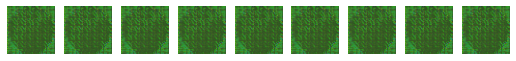

Epoch: 39


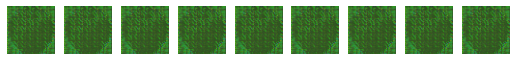

Epoch: 40


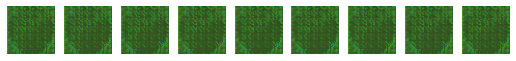

Epoch: 41


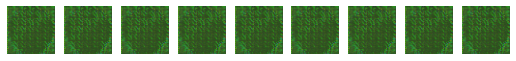

Epoch: 42


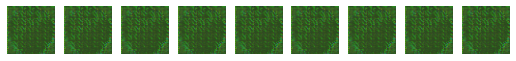

Epoch: 43


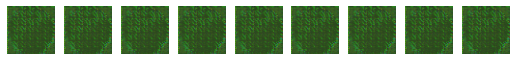

Epoch: 44


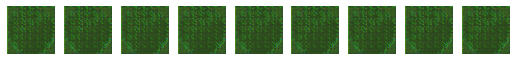

Epoch: 45


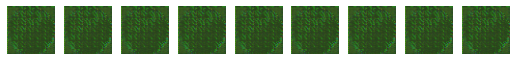

Epoch: 46


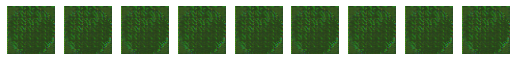

Epoch: 47


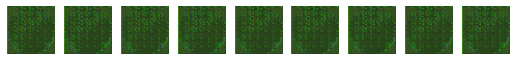

Epoch: 48


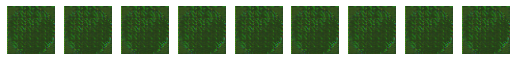

Epoch: 49


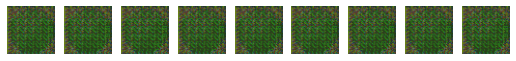

In [20]:
train_gan(gan, dataset, batch_size, coding_size, 50)